## Item 1
Deberá ejecutar tres algoritmos de clustering: K-Means, K-Means++ y
MeanShift, utilizando al menos cuatro configuraciones distintas para cada técnica
(deberá justificar la elección de parámetros). Para el entrenamiento, use únicamente
el 80% de los datos, omitiendo la etiqueta Y. A continuación, evalúe las doce
configuraciones obtenidas mediante una métrica de su elección (por ejemplo,
Silhouette Score) y seleccione las tres de mejor desempeño. Luego, aplique cada
una de estas configuraciones al 20% restante de los datos, asignando a cada muestra
el cluster correspondiente (obtenidos desde el entrenamiento). Finalmente, compare
la etiqueta Y real de cada muestra con la etiqueta dominante dentro del cluster al
que pertenece y analice si este procedimiento resulta razonable para asignar
etiquetas faltantes.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score, classification_report


In [24]:
housing = fetch_california_housing()
x = housing.data
x = StandardScaler().fit_transform(x)
df_x = pd.DataFrame(x, columns=housing.feature_names)

y = housing.target
y = pd.qcut(y, q=4, labels=[0,1,2,3])

Q1 = df_x.quantile(0.25)
Q3 = df_x.quantile(0.75)
IQR = Q3 - Q1
mask = ((df_x >= (Q1 - 1.5 * IQR)) & (df_x <= (Q3 + 1.5 * IQR))).all(axis=1)

x = df_x[mask].values
y = y[mask]

train_data, test_data, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

df_housing = pd.DataFrame(train_data, columns=housing.feature_names)
df_price = pd.DataFrame(y_train, columns=['MedHouseVal'])

print(df_price.head())
print(df_housing.head())
print(df_price.shape)
print(df_housing.shape)

  MedHouseVal
0           0
1           2
2           1
3           2
4           2
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.692224  1.856182 -0.164209  -0.225314   -0.388964 -0.056161  1.675236   
1  1.440501 -0.924851  0.542618  -0.331023    1.155496  0.027737 -0.628242   
2 -0.217063 -0.050812 -0.463903  -0.061124   -0.705097  0.018773 -0.838925   
3 -0.148107 -0.209729 -0.007052  -0.104967   -0.592067 -0.033221 -0.838925   
4  0.644302  0.346478  0.141353  -0.096247   -0.607078  0.006718 -0.642287   

   Longitude  
0  -1.218026  
1   0.409140  
2   0.678670  
3   0.843383  
4   0.553888  
(13473, 1)
(13473, 8)


## Mean-shift

In [25]:
from sklearn.cluster import estimate_bandwidth, get_bin_seeds, MeanShift

In [26]:
qt = 0.06
nsamples = 10000
bandwidth = estimate_bandwidth(train_data, quantile=qt, n_samples=nsamples)
# quantile es el porcentaje de puntos que se consideran vecinos (Sensibilidad)

seeds = get_bin_seeds(train_data, bin_size=bandwidth, min_bin_freq=1)
#Ajusta la cantidad de puntos iniciales (semillas) para el algoritmo

# <-- Mean Shift Clustering -->
ms = MeanShift(bandwidth=bandwidth, seeds=seeds)
ms.fit(train_data)
cluster_centers = ms.cluster_centers_
labels = ms.labels_
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters: %d" % n_clusters_)

# <-- Evaluación del clustering -->
silhouette_vals = silhouette_score(train_data, labels)
print(f'Silhouette Score: {silhouette_vals}')

# <-- Mapeo de clusters a etiquetas reales -->
mapa_clusters = {}
print("Etiquetas reales:", np.unique(y_train))
for cluster_id in np.unique(labels):
    if cluster_id == -1:
        continue
    etiquetas_reales_en_cluster = y_train[labels == cluster_id] #Retorna array con las etiquetas reales de los puntos en el cluster
    print(f'Cluster {cluster_id}: etiquetas reales {etiquetas_reales_en_cluster}')
    etiqueta_dominante = mode(etiquetas_reales_en_cluster, keepdims=False)[0] #Calcula la moda (etiqueta más frecuente) en el cluster
    print(f'Cluster {cluster_id}: etiqueta dominante {etiqueta_dominante}')
    mapa_clusters[cluster_id] = etiqueta_dominante # Mapea el id del cluster a la etiqueta dominante
print("Mapa de clusters a etiquetas reales:", mapa_clusters)
   
cluster_test = ms.predict(test_data)
print("Clusters predichos para datos de prueba:", cluster_test)
y_pred = np.array([mapa_clusters.get(cluster_id, -1) for cluster_id in cluster_test])
print("Etiquetas predichas para datos de prueba:", y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Number of estimated clusters: 2
Silhouette Score: 0.3835299045591097
Etiquetas reales: [0 1 2 3]
Cluster 0: etiquetas reales [2, 1, 2, 2, 1, ..., 3, 3, 2, 1, 3]
Length: 8030
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 0: etiqueta dominante 2
Cluster 1: etiquetas reales [0, 0, 2, 0, 1, ..., 0, 0, 3, 2, 0]
Length: 5443
Categories (4, int64): [0 < 1 < 2 < 3]
Cluster 1: etiqueta dominante 0
Mapa de clusters a etiquetas reales: {np.int64(0): np.int64(2), np.int64(1): np.int64(0)}
Clusters predichos para datos de prueba: [0 0 0 ... 1 0 1]
Etiquetas predichas para datos de prueba: [2 2 2 ... 0 2 0]
Accuracy: 0.29593351142772334
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.49      0.37       828
           1       0.00      0.00      0.00       827
           2       0.29      0.66      0.40       898
           3       0.00      0.00      0.00       816

    accuracy                           0.30      3369
   macro avg       

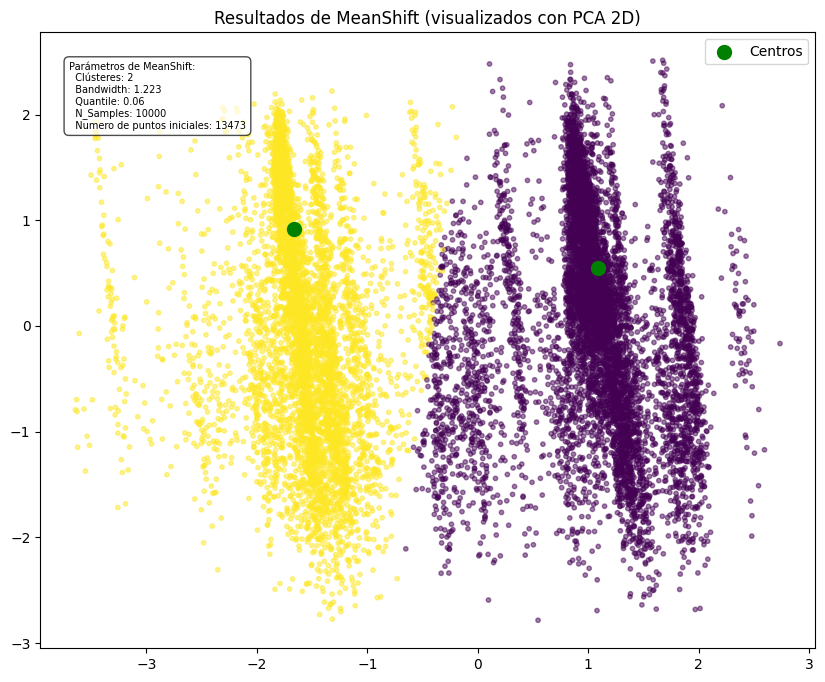

In [27]:
grafico_2d = PCA(n_components=2, random_state=42)
train_data_2d = grafico_2d.fit_transform(train_data)
centros_2d = grafico_2d.transform(cluster_centers)

plt.figure(figsize=(10,8))

plt.scatter(
    train_data_2d[:, 0],  # Eje X (Componente 1)
    train_data_2d[:, 1],  # Eje Z (Componente 3)
    c=labels,          # Color basado en el clúster
    cmap='viridis',
    s=10,
    alpha=0.5
)
plt.scatter(
    centros_2d[:, 0],
    centros_2d[:, 1],
    color='green',
    s=100,
    zorder=10,
    marker='o',
    label='Centros'
)

param_string = (
    f"Parámetros de MeanShift:\n"
    f"  Clústeres: {n_clusters_}\n"
    f"  Bandwidth: {bandwidth:.3f}\n"
    f"  Quantile: {qt}\n"
    f"  N_Samples: {nsamples}\n"
    f"  Numero de puntos iniciales: {len(train_data)}"
)

plt.text(
    -3.7, 2.5, param_string,
    ha='left', va='top',
    fontsize=7,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
)

plt.title('Resultados de MeanShift (visualizados con PCA 2D)')
plt.legend()
plt.show()

#

## K-Means

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
train_data_kmeans = pd.DataFrame(train_data)
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(train_data_kmeans)
kmeans_labels = kmeans.labels_
kmeans_centers = kmeans.cluster_centers_
print(train_data_kmeans.head())
print(len(np.unique(kmeans_labels)))

# <-- Evaluación del clustering -->
silhouette_vals = silhouette_score(train_data, kmeans_labels)
print(f'Silhouette Score: {silhouette_vals}')

# <-- Mapeo de clusters a etiquetas reales -->
mapa_clusters_kmeans = {}
print("Etiquetas reales:", np.unique(y_train))
for cluster_id in np.unique(kmeans_labels):
    if cluster_id == -1:
        continue
    etiquetas_reales_en_cluster = y_train[kmeans_labels == cluster_id] #Retorna array con las etiquetas reales de los puntos en el cluster
    print(f'Cluster {cluster_id}: etiquetas reales {etiquetas_reales_en_cluster}')
    etiqueta_dominante = mode(etiquetas_reales_en_cluster, keepdims=False)[0] #Calcula la moda (etiqueta más frecuente) en el cluster
    print(f'Cluster {cluster_id}: etiqueta dominante {etiqueta_dominante}')
    mapa_clusters_kmeans[cluster_id] = etiqueta_dominante # Mapea el id del cluster a la etiqueta dominante
print("Mapa de clusters a etiquetas reales:", mapa_clusters_kmeans)

cluster_test_kmeans = kmeans.predict(test_data)
print("Clusters predichos para datos de prueba:", cluster_test_kmeans)
y_pred_kmeans = np.array([mapa_clusters_kmeans.get(cluster_id, -1) for cluster_id in cluster_test_kmeans])
print("Etiquetas predichas para datos de prueba:", y_pred_kmeans)
accuracy = accuracy_score(y_test, y_pred_kmeans)
print(f'Accuracy: {accuracy}')
print("Classification Report:")
print(classification_report(y_test, y_pred_kmeans, zero_division=0))

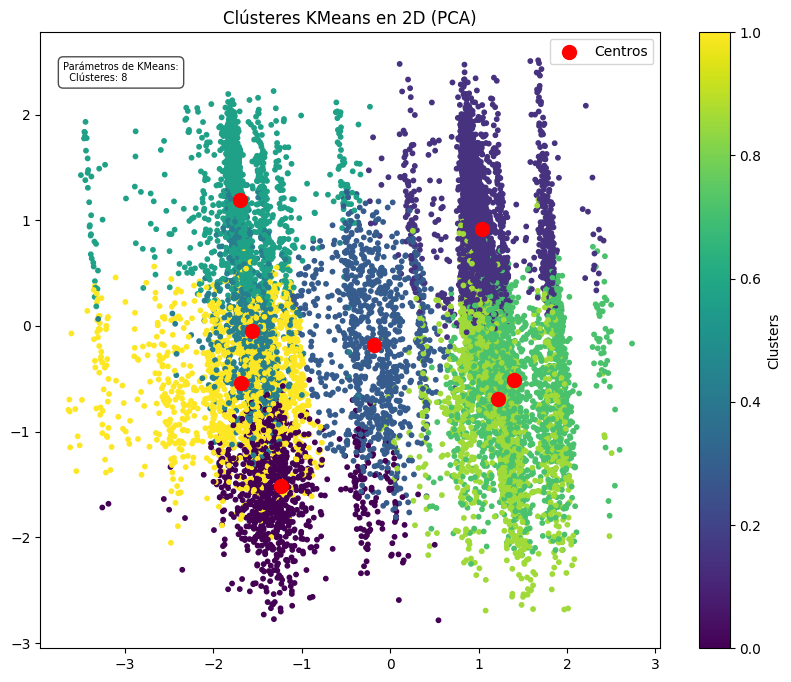

In [36]:
grafico_2d_kmeans = PCA(n_components=2, random_state=42)
train_data_2d = grafico_2d_kmeans.fit_transform(train_data_kmeans)
centros_2d = grafico_2d_kmeans.transform(kmeans_centers)
plt.figure(figsize=(10, 8))
plt.scatter(train_data_2d[:, 0], train_data_2d[:, 1],
            c=kmeans_labels, cmap='viridis', s=10)
plt.scatter(
    centros_2d[:, 0],
    centros_2d[:, 1],
    color='red',
    s=100,
    zorder=10,
    marker='o',
    label='Centros'
)
param_string = (
    f"Parámetros de KMeans:\n"
    f"  Clústeres: {kmeans.n_clusters}"
)
plt.text(
    -3.7, 2.5, param_string,
    ha='left', va='top',
    fontsize=7,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
)
plt.legend()
plt.title('Clústeres KMeans en 2D (PCA)')
plt.colorbar(label='Clusters')
plt.show()